# Generate word key

In [ ]:
import pandas as pd
import uuid
import os
import glob

# define relative path
path = '../res'
# Find all CSV files in the directory
csv_pattern = os.path.join(path, '*.csv')
csv_files = glob.glob(csv_pattern)

for csv_file in csv_files:
    
    print(f"\nProcessing: {os.path.basename(csv_file)}")
    
    # Load the CSV file
    df = pd.read_csv(csv_file)
    print(f"  Loaded {len(df)} rows")
    
    # Check if word_key column exists
    if 'word_key' in df.columns:
        print(f"  ✓ word_key column already exists - skipping")
        continue
    
    # Add UUID keys
    print(f"  Adding word_key column with UUID keys...")
    df['word_key'] = [str(uuid.uuid4()) for _ in range(len(df))]
    
    # Save back to the same file
    df.to_csv(csv_file, index=False)
    print(f"  ✓ Saved {len(df)} rows with UUID keys")



# Parse reading story

In [ ]:
import os
import re
import glob
import pandas as pd

path = r"/Volumes/GBLDrive/MindlessReading/Data/s10014/eye"

# load run dataset
folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
r_folders = [f for f in folders if re.search(r'_r[1-5]_', f)]
r_folders_sorted = sorted(r_folders, key=lambda x: int(re.search(r'_r(\d+)_', x).group(1)))

for folder in r_folders_sorted:
    folder_path = os.path.join(path, folder)
   
    # Look for _Message.csv file
    message_files = [f for f in os.listdir(folder_path) if f.endswith('_Message.csv')]

    if len(message_files) != 1:
        raise ValueError('Expected exactly 1 message file')
    
    df_msg = pd.read_csv(os.path.join(folder_path, message_files[0]))
    break

msg = 'TRIALID 1'
matching_indices = df_msg[df_msg['text'] == msg].index

if len(matching_indices) == 1:
   target_row = matching_indices[0] + 1  # Row 1 after the matching row
   
   if target_row < len(df_msg):
       text_value = df_msg.loc[target_row, 'text']
       reading_name = text_value.split('/')[1]
   else:
       raise ValueError('Cannot extract reading name')
else:
   raise ValueError('No reading data file found matching pattern')

res_path = '../res'
csv_pattern = os.path.join(res_path, f'{reading_name}*.csv')
matching_files = glob.glob(csv_pattern)

if matching_files:
   csv_file = matching_files[0]
   df_reading = pd.read_csv(csv_file)




# Manage files for OSF

## Copy raw data

In [1]:
import os
import re
import shutil
# Define the root directory containing subject folders
# root_dir = "F:/MindlessReading/Data"
root_dir = r"/Volumes/GBLDrive/MindlessReading/Data"

# Define the expected number of files in each folder
expected_files_count = 5

# Regular expression to match subject folder names (s followed by exactly 5 digits)
subject_pattern = re.compile(r"^s\d{5}$")

# Get the list of subject folders that match the pattern
subjects = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)) and subject_pattern.match(d)]

# Define the destination directory for raw data
raw_data_dir = os.path.join(r"/Users/hsun11/Desktop/raw_data")

print(f"Found {len(subjects)} subjects matching pattern")
print(f"Raw data will be saved to: {raw_data_dir}")
print("-" * 50)

# Create the main raw_data directory
os.makedirs(raw_data_dir, exist_ok=True)

success_count = 0
skipped_count = 0
total_copied_files = {"eye": 0, "log": 0, "eeg": 0}

for subject in sorted(subjects):
    print(f"Processing subject: {subject}")
    
    # Source paths
    source_subject_dir = os.path.join(root_dir, subject)
    source_eye_dir = os.path.join(source_subject_dir, "eye")
    source_log_dir = os.path.join(source_subject_dir, "log")
    source_eeg_dir = os.path.join(source_subject_dir, "eeg")
    
    # Destination paths
    dest_subject_dir = os.path.join(raw_data_dir, subject)
    dest_eye_dir = os.path.join(dest_subject_dir, "eye")
    dest_log_dir = os.path.join(dest_subject_dir, "log")
    dest_eeg_dir = os.path.join(dest_subject_dir, "eeg")
    
    # Create destination directories
    os.makedirs(dest_eye_dir, exist_ok=True)
    os.makedirs(dest_log_dir, exist_ok=True)
    os.makedirs(dest_eeg_dir, exist_ok=True)
    
    # Check if destination folders already have the complete set of files
    existing_asc_files = [f for f in os.listdir(dest_eye_dir) if f.endswith('.asc')] if os.path.exists(dest_eye_dir) else []
    existing_csv_files = [f for f in os.listdir(dest_log_dir) if f.endswith('.csv')] if os.path.exists(dest_log_dir) else []
    existing_bdf_files = [f for f in os.listdir(dest_eeg_dir) if f.endswith('.bdf')] if os.path.exists(dest_eeg_dir) else []
    
    if (len(existing_asc_files) == expected_files_count and 
        len(existing_csv_files) == expected_files_count and 
        len(existing_bdf_files) == expected_files_count):
        print(f"  ⏭️  Skipping {subject} - already has complete set:")
        print(f"    - {len(existing_asc_files)} .asc files in eye folder")
        print(f"    - {len(existing_csv_files)} .csv files in log folder")
        print(f"    - {len(existing_bdf_files)} .bdf files in eeg folder")
        skipped_count += 1
        print()
        continue
    
    copied_files = {"eye": [], "log": [], "eeg": []}
    errors = []
    
    try:
        # Copy .asc files from eye folder
        if os.path.exists(source_eye_dir):
            asc_files = [f for f in os.listdir(source_eye_dir) if f.endswith('.asc')]
            
            if len(asc_files) == expected_files_count:
                for asc_file in asc_files:
                    source_file = os.path.join(source_eye_dir, asc_file)
                    dest_file = os.path.join(dest_eye_dir, asc_file)
                    shutil.copyfile(source_file, dest_file)
                    copied_files["eye"].append(asc_file)
            else:
                errors.append(f"Expected {expected_files_count} .asc files, found {len(asc_files)}")
        else:
            errors.append("Eye folder does not exist")
        
        # Copy .csv files from log folder
        if os.path.exists(source_log_dir):
            csv_files = [f for f in os.listdir(source_log_dir) if f.endswith('.csv')]
            
            if len(csv_files) == expected_files_count:
                for csv_file in csv_files:
                    source_file = os.path.join(source_log_dir, csv_file)
                    dest_file = os.path.join(dest_log_dir, csv_file)
                    shutil.copyfile(source_file, dest_file)
                    copied_files["log"].append(csv_file)
            else:
                errors.append(f"Expected {expected_files_count} .csv files, found {len(csv_files)}")
        else:
            errors.append("Log folder does not exist")
        
        # Copy .bdf files from eeg folder
        if os.path.exists(source_eeg_dir):
            bdf_files = [f for f in os.listdir(source_eeg_dir) if f.endswith('.bdf')]
            
            if len(bdf_files) == expected_files_count:
                for bdf_file in bdf_files:
                    source_file = os.path.join(source_eeg_dir, bdf_file)
                    dest_file = os.path.join(dest_eeg_dir, bdf_file)
                    shutil.copyfile(source_file, dest_file)
                    copied_files["eeg"].append(bdf_file)
            else:
                errors.append(f"Expected {expected_files_count} .bdf files, found {len(bdf_files)}")
        else:
            errors.append("EEG folder does not exist")
            
    except Exception as e:
        errors.append(f"Error copying files: {str(e)}")
    
    # Report results for this subject
    if errors:
        print(f"  ❌ Errors for {subject}:")
        for error in errors:
            print(f"    - {error}")
    else:
        print(f"  ✅ Successfully copied:")
        print(f"    - {len(copied_files['eye'])} .asc files from eye folder")
        print(f"    - {len(copied_files['log'])} .csv files from log folder")
        print(f"    - {len(copied_files['eeg'])} .bdf files from eeg folder")
        success_count += 1
        total_copied_files["eye"] += len(copied_files["eye"])
        total_copied_files["log"] += len(copied_files["log"])
        total_copied_files["eeg"] += len(copied_files["eeg"])
    
    print()

# Summary
print("=" * 50)
print("SUMMARY:")
print(f"Successfully processed: {success_count}/{len(subjects)} subjects")
print(f"Skipped (already had files): {skipped_count}/{len(subjects)} subjects")
print(f"Total .asc files copied: {total_copied_files['eye']}")
print(f"Total .csv files copied: {total_copied_files['log']}")
print(f"Total .bdf files copied: {total_copied_files['eeg']}")
print(f"Raw data directory: {raw_data_dir}")

Found 45 subjects matching pattern
Raw data will be saved to: /Users/hsun11/Desktop/raw_data
--------------------------------------------------
Processing subject: s10014
  ✅ Successfully copied:
    - 5 .asc files from eye folder
    - 5 .csv files from log folder
    - 5 .bdf files from eeg folder

Processing subject: s10052
  ✅ Successfully copied:
    - 5 .asc files from eye folder
    - 5 .csv files from log folder
    - 5 .bdf files from eeg folder

Processing subject: s10059
  ✅ Successfully copied:
    - 5 .asc files from eye folder
    - 5 .csv files from log folder
    - 5 .bdf files from eeg folder

Processing subject: s10073
  ✅ Successfully copied:
    - 5 .asc files from eye folder
    - 5 .csv files from log folder
    - 5 .bdf files from eeg folder

Processing subject: s10081
  ✅ Successfully copied:
    - 5 .asc files from eye folder
    - 5 .csv files from log folder
    - 5 .bdf files from eeg folder

Processing subject: s10084
  ✅ Successfully copied:
    - 5 .asc f

## Generate demographic information

In [8]:
import pandas as pd
import os

# Load the Excel file
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file_name = "demo_info.xlsx"  # Update path if needed
df = pd.read_excel(os.path.join(path, file_name))

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Find all subject folders from raw_data folder
raw_data_dir = r"/Users/hsun11/Desktop/raw_data"
subject_pattern = re.compile(r"^s\d{5}$")

# Get subject IDs from raw_data folder
subject_ids = [d for d in os.listdir(raw_data_dir) 
               if os.path.isdir(os.path.join(raw_data_dir, d)) and subject_pattern.match(d)]

print(f"Found {len(subject_ids)} subjects in raw_data folder")
subject_nums = [int(s[1:]) for s in subject_ids]

# Filter by participant ID
df_filtered = df[df['participant_id'].isin(subject_nums)].copy()

# Age: ensure numeric and compute stats
df_filtered['age'] = pd.to_numeric(df_filtered['age'], errors='coerce')
age_min = df_filtered['age'].min()
age_max = df_filtered['age'].max()
age_median = df_filtered['age'].median()
age_mean = df_filtered['age'].mean()

# Gender: clean and count
df_filtered['gender_clean'] = df_filtered['gender'].str.strip().str.lower()
df_filtered['gender_clean'] = df_filtered['gender_clean'].replace({
    'female': 'female',
    'male': 'male',
    'nonbinary': 'non-binary',
    'non-binary': 'non-binary',
    'gender-nonconforming': 'non-binary',
    'transgender male': 'non-binary'
})
gender_counts = df_filtered['gender_clean'].value_counts()

# Handedness: clean and count
df_filtered['handness_clean'] = df_filtered['handness'].str.strip().str.lower()
df_filtered['handness_clean'] = df_filtered['handness_clean'].replace({
    'right': 'right',
    'left': 'left',
    'left, but used right-handed setup': 'left',
    'left-handed setup': 'left',
    'left, but used right-handed setup for mouse and keyboard': 'left',
    'ambidextrous (left-hand dominant)': 'left'
})
handness_counts = df_filtered['handness_clean'].value_counts()

# Print results
print("=" * 50)
print("DEMOGRAPHIC ANALYSIS")
print("=" * 50)
print(f"Total subjects analyzed: {len(df_filtered)}")
print()
print(f"Age range: {age_min} - {age_max}")
print(f"Median age: {age_median}")
print(f"Mean age: {age_mean:.2f}")
print()
print("Gender distribution:")
for gender, count in gender_counts.items():
    percentage = (count / len(df_filtered)) * 100
    print(f"  {gender}: {count} ({percentage:.1f}%)")
print()
print("Handedness distribution:")
for hand, count in handness_counts.items():
    percentage = (count / len(df_filtered)) * 100
    print(f"  {hand}: {count} ({percentage:.1f}%)")

# Optional: Show subjects that are in raw_data but missing from demographics
missing_subjects = [s for s in subject_nums if s not in df['participant_id'].values]
if missing_subjects:
    print()
    print(f"Warning: {len(missing_subjects)} subjects in raw_data have no demographic data:")
    print(f"Missing: {sorted(missing_subjects)}")

# Save filtered demographics to CSV in raw_data folder
output_file = os.path.join(raw_data_dir, "subject_demographics_information.csv")
df_filtered.to_csv(output_file, index=False)
print()
print(f"✅ Saved filtered demographics to: {output_file}")
print(f"   Contains {len(df_filtered)} subjects with {len(df_filtered.columns)} columns")

Found 45 subjects in raw_data folder
DEMOGRAPHIC ANALYSIS
Total subjects analyzed: 45

Age range: 18 - 64
Median age: 20.0
Mean age: 22.49

Gender distribution:
  female: 31 (68.9%)
  male: 9 (20.0%)
  non-binary: 5 (11.1%)

Handedness distribution:
  right: 38 (84.4%)
  left: 7 (15.6%)

✅ Saved filtered demographics to: /Users/hsun11/Desktop/raw_data/subject_demographics_information.csv
   Contains 45 subjects with 8 columns


## Copy processed data

In [ ]:
import os
import re
import shutil
import glob

# Define the root directory containing subject folders
# root_dir = "F:/MindlessReading/Data"
root_dir = r"/Volumes/GBLDrive/MindlessReading/Data"

# Define the expected number of files in each folder
expected_files_count = 5

# Regular expression to match subject folder names (s followed by exactly 5 digits)
subject_pattern = re.compile(r"^s\d{5}$")

# Get the list of subject folders that match the pattern
subjects = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)) and subject_pattern.match(d)]

# Define the destination directory for processed data
processed_data_dir = os.path.join(r"/Users/hsun11/Desktop/processed_data")

print(f"Found {len(subjects)} subjects matching pattern")
print(f"Processed data will be saved to: {processed_data_dir}")
print("-" * 50)

# Create the main processed_data directory
os.makedirs(processed_data_dir, exist_ok=True)

# Define CSV file patterns to copy
csv_patterns = [
    '*end2_sr*.csv',
    '*end2_tp*.csv', 
    '*end5_sr*.csv',
    '*end5_tp*.csv',
    '*mw_fixed_sr*.csv',
    '*mw_fixed_tp*.csv',
    '*page_fixed_sr*.csv',
    '*page_fixed_tp*.csv',
    '*default_sr*.csv',
    '*slide2.0*.csv'
]

for subject in sorted(subjects):
    print(f"Processing subject: {subject}")
    
    subject_path = os.path.join(root_dir, subject)
    subject_processed_dir = os.path.join(processed_data_dir, subject)
    
    # Create subject directory in processed_data
    os.makedirs(subject_processed_dir, exist_ok=True)
    
    # Copy 5 folders from eye subdirectory
    eye_dir = os.path.join(subject_path, "eye")
    if os.path.exists(eye_dir):
        eye_folders = [d for d in os.listdir(eye_dir) if os.path.isdir(os.path.join(eye_dir, d))]
        
        if len(eye_folders) >= 5:
            # Copy first 5 folders (or you can modify this logic to select specific folders)
            for i, folder in enumerate(sorted(eye_folders)[:5]):
                src_folder = os.path.join(eye_dir, folder)
                dst_folder = os.path.join(subject_processed_dir, 'eye', folder)
                
                try:
                    shutil.copytree(src_folder, dst_folder)
                    # print(f"  Copied eye folder: {folder}")
                except Exception as e:
                    print(f"  Error copying eye folder {folder}: {e}")
        else:
            print(f"  Warning: Only found {len(eye_folders)} folders in eye directory, expected 5")
    else:
        print(f"  Warning: Eye directory not found for subject {subject}")
    
    # Copy CSV files with specified patterns
    for pattern in csv_patterns:
        matching_files = glob.glob(os.path.join(subject_path, pattern))
        
        for file_path in matching_files:
            file_name = os.path.basename(file_path)
            dst_path = os.path.join(subject_processed_dir, file_name)
            
            try:
                shutil.copy2(file_path, dst_path)
                # print(f"  Copied CSV: {file_name}")
                csv_files_copied += 1
            except Exception as e:
                print(f"  Error copying CSV {file_name}: {e}")
    
    print("-" * 30)

print("Processing complete!")

Found 45 subjects matching pattern
Processed data will be saved to: /Users/hsun11/Desktop/processed_data
--------------------------------------------------
Processing subject: s10014
  Copied eye folder: s014_r1_2023_11_29_09_28_data
  Copied eye folder: s014_r2_2023_11_29_09_56_data
  Copied eye folder: s014_r3_2023_11_29_10_15_data
  Copied eye folder: s014_r4_2023_11_29_10_28_data
  Copied eye folder: s014_r5_2023_11_29_10_43_data
  Copied CSV: s10014_R_features_end2_sr.csv
  Copied CSV: s10014_L_features_end2_sr.csv
  Copied CSV: s10014_R_features_end2_tp.csv
  Copied CSV: s10014_L_features_end2_tp.csv
  Copied CSV: s10014_L_features_end5_sr.csv
  Copied CSV: s10014_R_features_end5_sr.csv
  Copied CSV: s10014_L_features_end5_tp.csv
  Copied CSV: s10014_R_features_end5_tp.csv
  Copied CSV: s10014_L_features_mw_fixed_sr.csv
  Copied CSV: s10014_R_features_mw_fixed_sr.csv
  Copied CSV: s10014_L_features_mw_fixed_tp.csv
  Copied CSV: s10014_R_features_mw_fixed_tp.csv
  Copied CSV: s100

KeyboardInterrupt: 

# Generate ML ready dataset

## Functions

In [1]:
import mne
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

def process_eeg_data(file_path):
    """
    Process EEG data and extract page start times.
    
    Parameters:
    file_path (str): Path to the EEG .set file
    
    Returns:
    tuple: (eeg_data, df_data, page_start_times, sampling_freq)
    """
    # Load EEG file
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    ch_names = raw.info['ch_names']
    
    # Get the data as numpy array
    data, times = raw.get_data(return_times=True)
    
    # Convert to dataframes
    eeg_data = pd.DataFrame(data.T, columns=ch_names)
    df_data = pd.DataFrame({'time': times})
    
    # Get sampling frequency and events
    fs = raw.info['sfreq']
    df_data['sfreq'] = fs
    
    events, event_id = mne.events_from_annotations(raw)
    
    # Extract page start times (condition 10 events)
    page_start_times = []
    
    if 'condition 10' in event_id:
        condition10_code = event_id['condition 10']
        condition10_events = events[events[:, 2] == condition10_code]
        
        if len(condition10_events) != 10:
            raise ValueError(f'Expected 10 pages, found {len(condition10_events)}')
        
        # Convert sample indices to time
        for event in condition10_events:
            page_sample = event[0]
            page_start_times.append(page_sample / fs)
    else:
        raise ValueError('condition 10 not found in event_id')
    
    # Clean up large variables to free memory
    del raw, data, times, events
    
    return pd.concat([eeg_data, df_data], axis=1), page_start_times, fs


def interpolate_blink(dfSamples, dfBlink, dfSaccade):
    """
    Interpolate left and right pupil sizes over blink periods. Modifies the
    dataframe of samples in place to change pupil dilation values to interpolated
    values, effectively removing blink artifacts. Saves interpolated data as csv.
    
    Uses saccades as t1 and t4. Contains adjustments recommended through conversation
    with Dr. J. Performs the interpolation over the normalized pupil dilation values.
    
    Inputs:
        - dfSamples: A dataframe containing samples for all subjects and all runs
        - dfBlink: A dataframe containing information about the eye in which a 
            blink occured and the time that that blink occured
        - dfSaccades: A dataframe of saccade events
        
    Returns:
        Interpolated dfSamples
    """
    # extracted from reading_analysis.py (author: HS)
    # interpolate the pupil size during the blink duration
    # http://dx.doi.org/10.6084/m9.figshare.688002
    

    # get time array from dfSamples
    sample_time = dfSamples['tSample'].to_numpy()

    # interpolate data for LEFT and RIGHT eye separately
    for eye in ['L', 'R']:
        # extract blink and saccade information for one eye
        dfBlink_ = dfBlink[dfBlink['eye']==eye]
        dfSaccade_ = dfSaccade[dfSaccade['eye']==eye]

        # truncate blink dataframe using the saccade information
        t_start = dfSaccade_['tStart'].min()
        t_end = dfSaccade_['tEnd'].max()
        mask = (dfBlink_['tStart'] > t_start) & (dfBlink_['tEnd'] < t_end)
        dfBlink_ = dfBlink_[mask]

        # convert df columns to np.arrays for interpolation
        col_names = [f'{eye}X', f'{eye}Y', f'{eye}Pupil']
        data_to_interpolate = []
        for col_name in col_names:
            data_to_interpolate.append(np.array(dfSamples[col_name]))

        # iterate throu each row of blink dataframe
        for index in np.arange(len(dfBlink_)):
            row = dfBlink_.iloc[index]
            # get the start and end time
            b_start = row['tStart'] 
            b_end = row['tEnd']
            # skip blinks out of range of dfSamples
            if (b_start < sample_time[0]) and (b_end > sample_time[-1]):
                continue

            # set t1 to be the end time of the last saccade before the blink
            #get all saccades before this blink
            previous_sac = dfSaccade_[dfSaccade_["tEnd"] < b_start]
            # get last saccade before this blink
            t1 = previous_sac["tEnd"].max()
            # set t4 to be the start time of the first saccade after the blink
            # get all saccades after this blink
            after_sac = dfSaccade_[dfSaccade_["tStart"] > b_end]
            # get the first saccade after this blink
            t2 = after_sac["tStart"].min()

            # check for missing vals in t1 or t4 and use fallback if needed
            # if pd.isna(t1) or pd.isna(t2):
            #     raise ValueError("t1/t2 are Na")
            
            # check the timing of saccades are within the time array for samples
            if (t1 > sample_time[0]) and (t2 < sample_time[-1]):
                # choose data points for interpolation function
                x = [t1,t2]
                y_ind = []
                for t in x:
                    y_ind.append(np.where(sample_time==t)[0][0])

                # loop thru all columns
                for col_name, col_data in zip(col_names, data_to_interpolate):
                    # create the 1D function for interpolation
                    y = col_data[y_ind]
                    interp_f = interp1d(x, y)           
                    #spl = CubicSpline(x, y)
                    
                    # generate mask for blink duration
                    mask = (sample_time > t1) & (sample_time < t2)
                    time_to_interpolate = sample_time[mask]
                    # use spl model to interpolate data during blink duration
                    interp_data = interp_f(time_to_interpolate)
                    
                    # update the dfSamples in place
                    dfSamples.loc[mask, col_name] = interp_data

    return dfSamples


def convert_eyelink_to_image_pixel(x_eyelink, y_eyelink):
        '''
        Convert eyeylink coords to pixel for image (1900 x 1442 pixels) 
        displayed at pos (0, 0) w/ size (1.3, 0.99) in PsychoPy.

        Parameters
        ----------
        x_eyelink : float
            DESCRIPTION. eyelink coord unit
        y_eyelink : float
            DESCRIPTION. eyelink coord unit

        Returns
        -------
        x_pixel : float
            DESCRIPTION. Image pixel unit
        y_pixel : float 
            DESCRIPTION. Image pixel unit 

        '''
        x_pixel = (x_eyelink-258) * 1900 / (1080*1.3)
        y_pixel = (y_eyelink-5.4) * 1442 / (1080*0.99)
        return x_pixel, y_pixel


def find_match(dfWords, coord_info, dist_max=1000):
    '''
    Match the clicks to words. 

    Parameters
    ----------
    dfWords : DataFrame
        DESCRIPTION. The dataframe for a single page. It should at least contain
        columns 'center_x', 'center_y', 'width', and 'height', which are 
        coordinate information of words in pixel unit
    click_pos : Tuple
        DESCRIPTION. The coordinate info (x, y) for a click in pixel unit

    Returns
    -------
    matched_index: int
        DESCRIPTION. The index value of matched word for input dataframe. 

    '''
    # compute the start and end positions of words
    words_x_start = dfWords['center_x'] - dfWords['width']/2
    words_x_end = dfWords['center_x'] + dfWords['width']/2
    words_y_start = dfWords['center_y'] - dfWords['height']/2
    words_y_end = dfWords['center_y'] + dfWords['height']/2
    
    # get x and y for the click
    pos_x, pos_y = coord_info
    
    # compute the distance between click and word boundry box
    dist_x_left = (words_x_start - pos_x)
    dist_x_right = (pos_x - words_x_end)
    dist_y_top = (words_y_start - pos_y)
    dist_y_bottom = (pos_y - words_y_end)
    
    # find the maximum distance from click to the word for x and y
    max_x = np.max(np.vstack((dist_x_left, dist_x_right, np.zeros(len(dist_x_left)))), axis=0)
    max_y = np.max(np.vstack((dist_y_top, dist_y_bottom, np.zeros(len(dist_y_top)))), axis=0)
    
    # calculate the distance using x and y
    dist = np.sqrt(np.square(max_x) + np.square(max_y))
    
    # check if the minimum dist exceeds threshold values
    if np.min(dist) < dist_max:
        matched_index = np.argmin(dist)
    else:
        matched_index = -1
    
    # return the index that has the shortest distance
    return matched_index

## Pipeline

In [ ]:
# Define the root directory containing subject folders
# root_dir = "F:/MindlessReading/Data"
root_dir = r"/Volumes/GBLDrive/MindlessReading/Data"

# Regular expression to match subject folder names (s followed by exactly 5 digits)
subject_pattern = re.compile(r"^s\d{5}$")

# Get the list of subject folders that match the pattern
subjects = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)) and subject_pattern.match(d)]

for subject_path in subjects:
    sub_id = re.search(r'^s\d{5}$', subject_path).group(0)
    

    

s10110


In [3]:
import os
import re
import glob
import pandas as pd
# Define the root directory containing subject folders
# root_dir = "F:/MindlessReading/Data"
root_dir = r"/Volumes/GBLDrive/MindlessReading/Data"
# Regular expression to match subject folder names (s followed by exactly 5 digits)
subject_pattern = re.compile(r"^s\d{5}$")

# Get the list of subject folders that match the pattern
subjects = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)) and subject_pattern.match(d)]

# define res path (relative)
res_path = '../res'

for sub_id in subjects:
    print('Start processing subject: ', sub_id)
    subject_path = os.path.join(root_dir, sub_id)
    # define path to save
    path_to_save = os.path.join(subject_path, 'ml_data')
    os.makedirs(path_to_save, exist_ok=True)

    # load subject page info dataframe
    file_path = os.path.join(subject_path, f'{sub_id}_R_features_default_sr.csv')
    df_page_info = pd.read_csv(file_path)

    # load raw eye datasets for each run
    eye_folder = os.path.join(subject_path, 'eye')
    folders = [f for f in os.listdir(eye_folder) if os.path.isdir(os.path.join(eye_folder, f))]
    r_folders = [f for f in folders if re.search(r'_r[1-5]_', f)]
    r_folders_sorted = sorted(r_folders, key=lambda x: int(re.search(r'_r(\d+)_', x).group(1)))

    for folder in r_folders_sorted:
        folder_path = os.path.join(eye_folder, folder)
        # get run number
        run_num = int(re.search(r'_r(\d+)_', folder).group(1))
        print('Run number: ', run_num)

        # load EEG file for the current run
        file_path = os.path.join(subject_path, 'eeg', 'ICAPruned', f'MR_{sub_id}_r{run_num}_ICAPruned.set')
        df_data, page_start_eeg, fs = process_eeg_data(file_path)

        # get the current run info
        df_page_run = df_page_info[df_page_info['run']==run_num].copy()
        eyelink_start_time = df_page_run['task_start'].iloc[0]
        # page start time in eyelink
        page_start_eye = df_page_run['page_start'] - eyelink_start_time

        # make sure time offsets between eeg and eyelink are consistent
        time_offsets = np.array(page_start_eeg) - np.array(page_start_eye)
        max_offset_allowed = 0.01
        if np.max(time_offsets) - np.min(time_offsets) > max_offset_allowed:
            raise ValueError('Time offsets between EEG and eyelink not consistent.')
        # use the mean to be the time offset (in seconds) for the current run
        time_offset = np.mean(time_offsets)

        # update eyelink time to match df_data array
        df_page_run['page_start_eeg'] = df_page_run['page_start'] - eyelink_start_time + time_offset
        df_page_run['page_end_eeg'] = df_page_run['page_end'] - eyelink_start_time + time_offset
        df_page_run['mw_onset'] = df_page_run['mw_onset'] - eyelink_start_time + time_offset
        df_page_run['mw_offset'] = df_page_run['mw_offset'] - eyelink_start_time + time_offset

        # get story name
        story_name = df_page_run['reading'].iloc[0]
        story_name = story_name.lower().replace(' ', '_')

        # load word coordinate file
        csv_pattern = os.path.join(res_path, f'{story_name}*.csv')
        matching_files = glob.glob(csv_pattern)
        df_word = pd.read_csv(matching_files[0])

        # load fixation file
        csv_pattern = os.path.join(folder_path, f'*Fixation.csv')
        matching_files = glob.glob(csv_pattern)
        df_fix = pd.read_csv(matching_files[0])

        # load blink file
        csv_pattern = os.path.join(folder_path, f'*Blink.csv')
        matching_files = glob.glob(csv_pattern)
        df_blink = pd.read_csv(matching_files[0])

        # load saccade file
        csv_pattern = os.path.join(folder_path, f'*Saccade.csv')
        matching_files = glob.glob(csv_pattern)
        df_sacc = pd.read_csv(matching_files[0])

        # load raw eye sample file (gaze position and pupil size)
        csv_pattern = os.path.join(folder_path, f'*Sample.csv')
        matching_files = glob.glob(csv_pattern)
        df_sample = pd.read_csv(matching_files[0])

        # interpolate eye samples during blinnk
        df_interp_sample = df_sample.copy()
        interpolate_blink(df_interp_sample, df_blink, df_sacc)
        # copy interpolated data into the samples dataframe
        for col in ['LX', 'LY', 'LPupil', 'RX', 'RY', 'RPupil']:
            df_sample[f'blink_interp_{col}'] = df_interp_sample[col]
        
        # loop through each page for matching fixation and word and inserting page-level information
        for _, row in df_page_run.iterrows():
            # get the current page number
            page_num = row['page']
            # get the page number start and end time
            page_start = row['page_start'] * 1000
            page_end = row['page_end'] * 1000

            # match fixation to the reading word
            # find the fixation and words for the current page
            df_word_page = df_word[df_word['page']==page_num]
            mask = (df_fix['tStart'] >= page_start) & (df_fix['tEnd'] <= page_end)
            df_fix_page = df_fix[mask]
            # loop through each fixation and match it to the closed word 
            for row_index, fix in df_fix_page.iterrows():
                # get the fixtaion position x and y
                x_eyelink = fix['xAvg']
                y_eyelink = fix['yAvg']
                # convert position x and y into image pixel unit
                fix_x, fix_y = convert_eyelink_to_image_pixel(x_eyelink, y_eyelink)
                
                # call function find the matched index
                matched_index = find_match(df_word_page, (fix_x, fix_y))
                
                if matched_index >= 0:
                    # store matched word info into fixations 
                    df_fix.at[row_index, 'fixed_word'] = df_word_page['words'].iloc[matched_index]
                    df_fix.at[row_index, 'fixed_word_key'] = df_word_page['word_key'].iloc[matched_index]
        

            # insert page start and end time to df_data
            page_mask = (df_data['time'] >= row['page_start_eeg']) & (df_data['time'] <= row['page_end_eeg'])
            df_data.loc[page_mask, 'first_pass_reading'] = True
            df_data.loc[page_mask, 'page_num'] = page_num
            df_data.loc[page_mask, 'page_start'] = row['page_start_eeg']
            df_data.loc[page_mask, 'page_end'] = row['page_end_eeg']
            df_data.loc[page_mask, 'page_dur'] = row['page_end_eeg'] - row['page_start_eeg']
            # insert mw start and end time to df_data
            mw_mask = (df_data['time'] >= row['mw_onset']) & (df_data['time'] <= row['mw_offset'])
            df_data.loc[mw_mask, 'is_mw'] = True
            df_data.loc[mw_mask, 'mw_onset'] = row['mw_onset']
            df_data.loc[mw_mask, 'mw_offset'] = row['mw_offset']
            df_data.loc[mw_mask, 'mw_dur'] = row['mw_offset'] - row['mw_onset']

        print('Aligning eye-tracking data into EEG time...')
        # insert current run information
        df_data['run_num'] = run_num
        df_data['story_name'] = story_name

        # insert fixations to df_data
        # align fixation time to eeg
        # 1. /1000: ms -> s
        # 2. - eyelink_start_time: take off the run start time
        # 3. + time_offset: add on the time offset between eeg and eye
        for col in ['tStart', 'tEnd']:
            df_fix[col] = df_fix[col]/1000 - eyelink_start_time + time_offset
        for _, row in df_fix.iterrows():
            mask = (df_data['time'] >= row['tStart']) & (df_data['time'] <= row['tEnd'])
            if mask.sum() > 0:
                df_data.loc[mask, 'is_fixation'] = True
                for col in df_fix.columns:
                    df_data.loc[mask, f'fix_{col}'] = row[col]
        
        # insert blinks to df_data
        for col in ['tStart', 'tEnd']:
            df_blink[col] = df_blink[col]/1000 - eyelink_start_time + time_offset
        for _, row in df_blink.iterrows():
            mask = (df_data['time'] >= row['tStart']) & (df_data['time'] <= row['tEnd'])
            if mask.sum() > 0:
                df_data.loc[mask, 'is_blink'] = True
                for col in df_blink.columns:
                    df_data.loc[mask, f'blink_{col}'] = row[col]

        # insert saccades to df_data
        for col in ['tStart', 'tEnd']:
            df_sacc[col] = df_sacc[col]/1000 - eyelink_start_time + time_offset
        for _, row in df_sacc.iterrows():
            mask = (df_data['time'] >= row['tStart']) & (df_data['time'] <= row['tEnd'])
            if mask.sum() > 0:
                df_data.loc[mask, 'is_saccade'] = True
                for col in df_sacc.columns:
                    df_data.loc[mask, f'sacc_{col}'] = row[col]

        # insert gaze position and pupil size to df_data
        df_sample['tSample'] = df_sample['tSample']/1000 - eyelink_start_time + time_offset
        # instead of interpolating, find the closest eye sample point time for each eeg data point
        eeg_times = df_data['time'].values
        sample_times = df_sample['tSample'].values
        for i, eeg_time in enumerate(eeg_times):
            # Find index of closest sample time
            closest_idx = np.argmin(np.abs(sample_times - eeg_time))
            
            # Check if it's within reasonable range (optional)
            time_diff = abs(sample_times[closest_idx] - eeg_time)
            if time_diff < 0.01:
                for col in df_sample.columns:
                    df_data.loc[i, col] = df_sample.iloc[closest_idx][col]
        
        dataset_name = f'{sub_id}_run{run_num}_ml_data.csv'
        df_data.to_csv(os.path.join(path_to_save, dataset_name), index=False)
        print(f'Subject {sub_id} run {run_num} has done! Data saved to {os.path.join(path_to_save, dataset_name)}\n')
    
    break
    


Start processing subject:  s10110
Run number:  1
Used Annotations descriptions: ['30', '40', 'MW_offset', 'MW_onset', 'condition 1', 'condition 10', 'condition 5', 'control_onset', 'control_sr', 's10110_1_0_control_onset', 's10110_1_0_control_sr', 's10110_1_1_control_onset', 's10110_1_1_control_sr', 's10110_1_2_MW_onset', 's10110_1_2_self_report', 's10110_1_3_MW_onset', 's10110_1_3_self_report', 's10110_1_4_control_onset', 's10110_1_4_control_sr', 's10110_1_5_control_onset', 's10110_1_5_control_sr', 's10110_1_6_MW_onset', 's10110_1_6_self_report', 's10110_1_7_MW_onset', 's10110_1_7_self_report', 's10110_1_8_control_onset', 's10110_1_8_control_sr', 's10110_1_9_MW_onset', 's10110_1_9_self_report', 'self_report']
Aligning eye-tracking data into EEG time...
Subject s10110 run 1 has done! Data saved to /Volumes/GBLDrive/MindlessReading/Data/s10110/ml_data/s10110_run1_ml_data.csv

Run number:  2
Used Annotations descriptions: ['30', '40', 'MW_offset', 'MW_onset', 'condition 1', 'condition 10

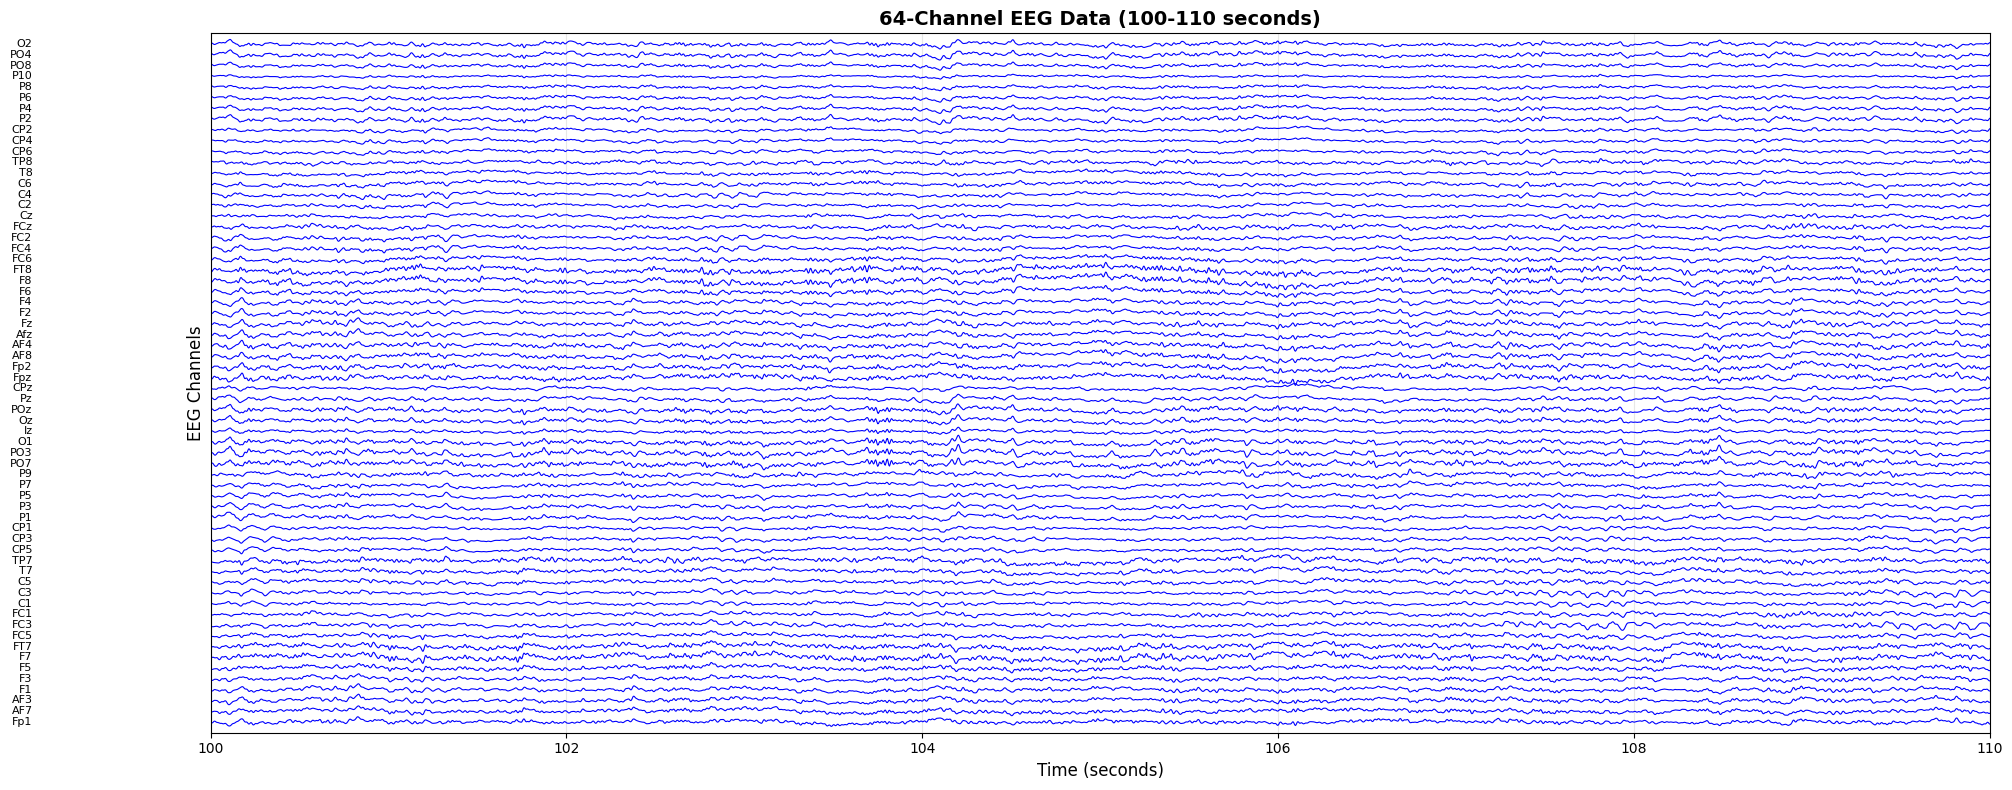

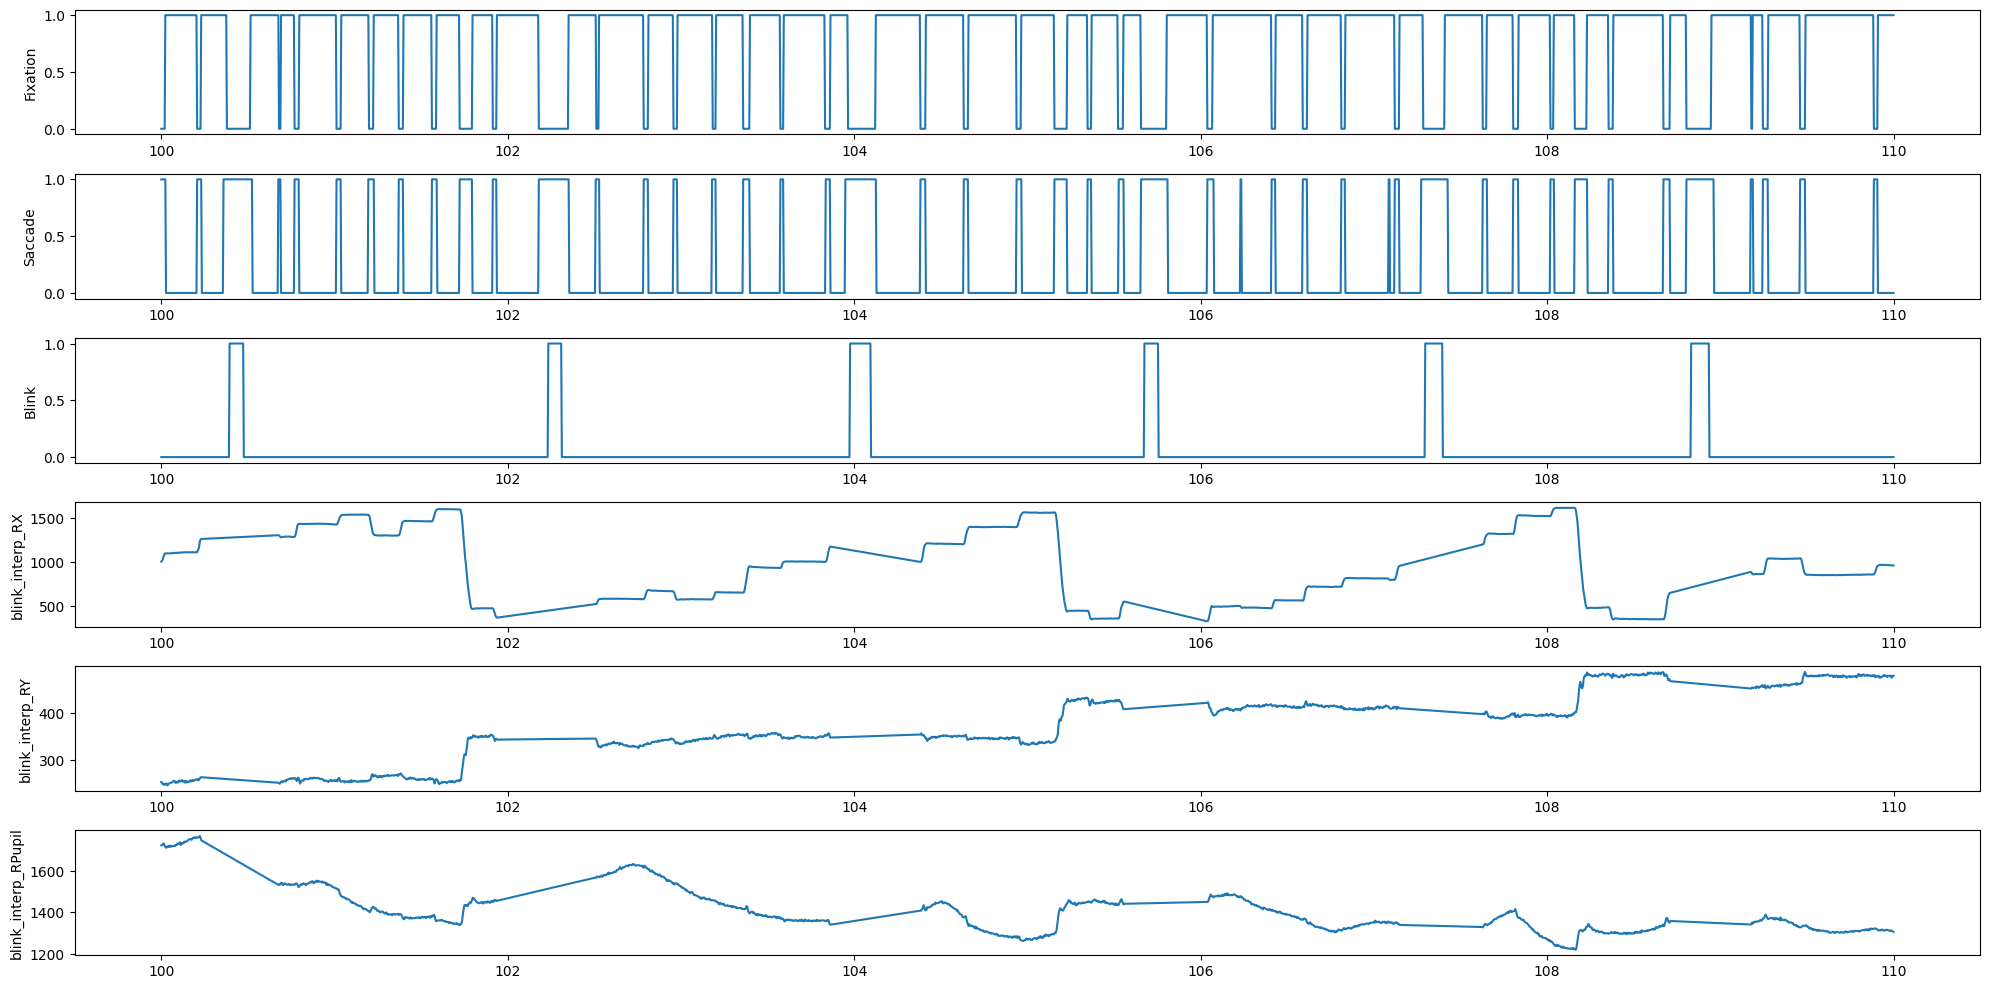

In [34]:
import numpy as np
import matplotlib.pyplot as plt

time_start = 100
time_end = 110

mask = (df_data['time'] >= time_start) & (df_data['time'] <= time_end)
ch_names = df_data.columns.values[:64]

df_to_plot = df_data[mask].copy()
eeg_data = np.array(df_to_plot[ch_names])
time = np.array(df_to_plot['time'])
# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Vertical spacing between channels
channel_spacing = 0.00005


# Plot each channel
for ch in range(len(ch_names)):
    # Offset each channel vertically
    y_offset = ch * channel_spacing
    ax.plot(time, eeg_data[:, ch] + y_offset, 'b-', linewidth=0.8)
    
    # Add channel labels
    ax.text(-0.1, y_offset, ch_names[ch], 
            verticalalignment='center', horizontalalignment='right',
            fontsize=8, transform=ax.get_yaxis_transform())

# Customize the plot
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('EEG Channels', fontsize=12)
ax.set_title('64-Channel EEG Data (100-110 seconds)', fontsize=14, fontweight='bold')

# Set y-axis limits and remove ticks
ax.set_ylim(-channel_spacing, len(ch_names) * channel_spacing)
ax.set_yticks([])

# Add grid for better readability
ax.grid(True, alpha=0.3)

# Set x-axis limits
ax.set_xlim(time_start, time_end)

plt.tight_layout()
plt.show()


# plot fix, blink, and saccade
# Create the plot with 6x1 subplots
fig, axes = plt.subplots(6, 1, figsize=(20, 10))
is_fixation = df_to_plot['is_fixation'].copy()
is_fixation = is_fixation.fillna(0)  # Replace NaN with 0
axes[0].plot(time, is_fixation)
axes[0].set_ylabel('Fixation')
axes[0].set_xlabel('')

is_sacc = df_to_plot['is_saccade'].copy()
is_sacc = is_sacc.fillna(0)  # Replace NaN with 0
axes[1].plot(time, is_sacc)
axes[1].set_ylabel('Saccade')
axes[1].set_xlabel('')

is_blink = df_to_plot['is_blink'].copy()
is_blink = is_blink.fillna(0)  # Replace NaN with 0
axes[2].plot(time, is_blink)
axes[2].set_ylabel('Blink')
axes[2].set_xlabel('')

plt_idx = 3
for col in ['blink_interp_RX', 'blink_interp_RY', 'blink_interp_RPupil']:
    axes[plt_idx].plot(time, df_to_plot[col])
    axes[plt_idx].set_ylabel(col)
    axes[plt_idx].set_xlabel('')
    plt_idx += 1

plt.tight_layout()


